In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import gudhi as gd
from utilsTopology import *
from utilsBaricentricNeuralNetwork import *
from utils import *
fontsize=16
from tqdm import tqdm

plt.rcParams.update({
    "axes.titlesize": 14,    
    "axes.labelsize": fontsize,   
})


mse_fn = tf.keras.losses.MeanSquaredError()

Persistent entropy ``measures'' the complexity of a topological space based on its persistence diagram $D = \{(b_i, d_i) \mid i \in I\}$

# Normal PE

$PE = - \sum_{i \in I} p_i \cdot \ln{p_i}$

where $p_i = \frac{\ell_i}{L}, \ell_i = d_i - b_i, L = \sum_{i \in I} \ell_i$.

\begin{equation}
    L_{PE} = |PE_{ref} - PE{pred}|
\end{equation}

## Point cloud without noise

100%|██████████| 100/100 [00:28<00:00,  3.51it/s]


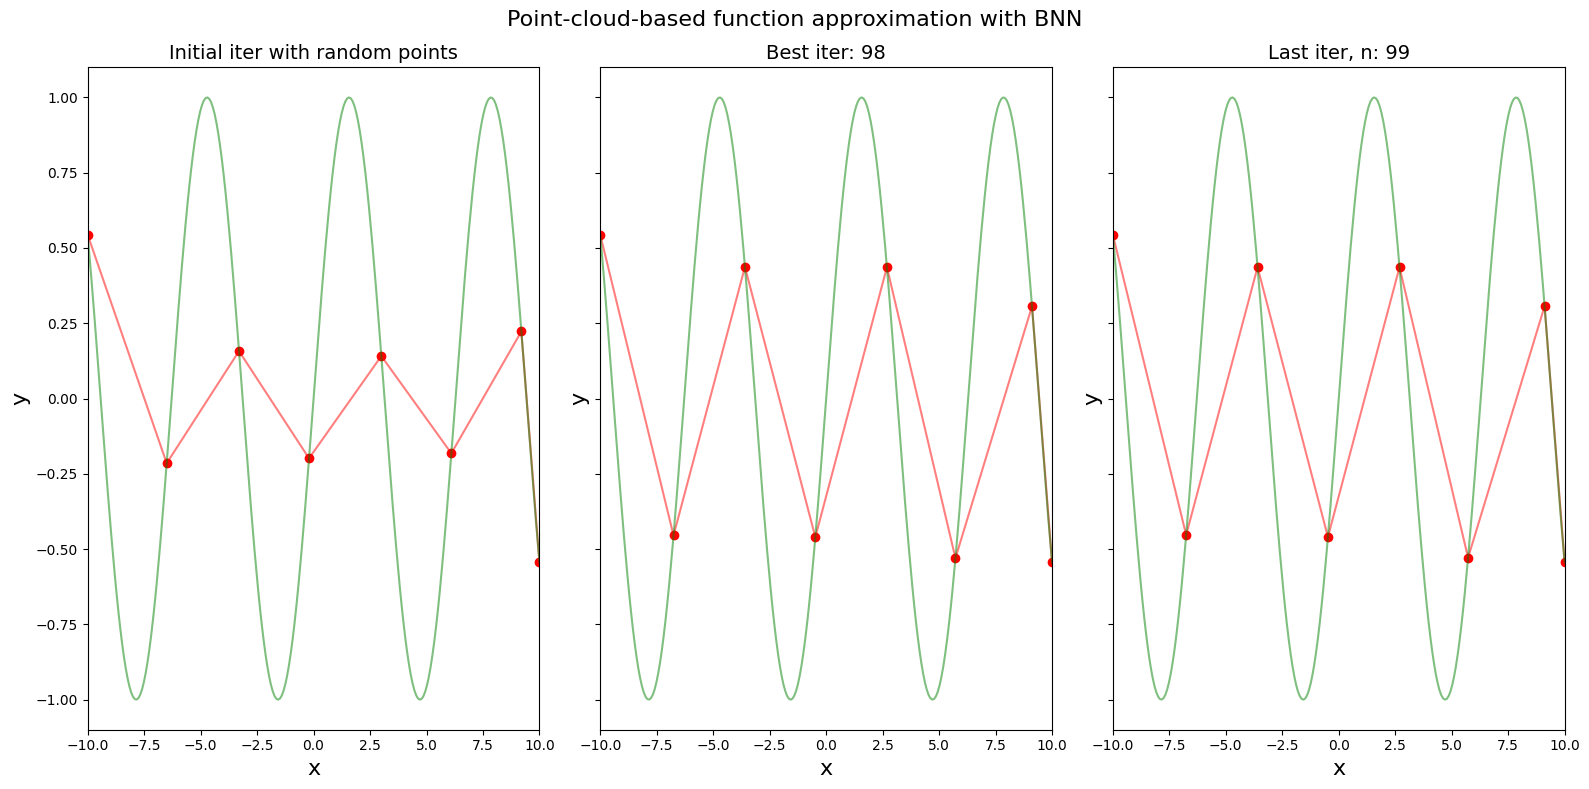

In [ ]:
domain =[-10,10]
num_points=250
function=np.sin
x_train, y_train = generate_training_data(function, (domain[0], domain[1]), num_points)
x_train = tf.constant(x_train,dtype=tf.float32)
y_train = tf.constant(y_train,dtype=tf.float32)

stbase = gd.SimplexTree()
for i in range(num_points-1):
    stbase.insert([i,i+1], -1e10) # aqui definimos que cada elemento esta conectado com su siguiente, ya que lo que tenemos es una linea, una serie temporal
layer = LowerStarLayer(simplextree=stbase)
dgmsRef = layer.call(tf.Variable(y_train))
dgmRef = dgmsRef[0][0]

PERef=persistent_entropy(dgmRef)
LWPERef=length_weighted_persistent_entropy(dgmRef)

x_points = tf.Variable([-10,-6.5,-3.3,-0.2,3.,6.1,9.2,10], dtype=tf.float32 ,trainable=True)
num_points_aprox = x_points.shape[0]

best_mse = float('inf')  
num_iter = 100  
best_iter = 0

metricas = {
    "$MSE$": [],
    "$PE$": [],
    "$LWPE$": [],
}

optimizer = tf.keras.optimizers.SGD(learning_rate=0.1)

for epoch in tqdm(range(num_iter)):
    with tf.GradientTape() as tape:
        tape.watch(x_points)
        y_points = interpolation_tf(x_train,y_train, x_points)
        points = tf.stack([x_points,y_points],axis=1)
        model = BaricentricNetwork(points)
        y_aprox = model(tf.expand_dims(x_train,axis=1))
        dgmsAprox = layer.call(y_aprox)
        dgmAprox = dgmsAprox[0][0]
        mseActual = mse_fn(y_train,y_aprox)
        PELoss = PersistentEntropyLoss()
        PELossValue = PELoss(dgmRef, dgmAprox)

    
    PEAproxActual=persistent_entropy(dgmAprox)
    LWPEAproxActual=length_weighted_persistent_entropy(dgmAprox)

    lossFunction = PersistentEntropyLoss()
    entropyLoss = lossFunction(dgmRef,dgmAprox)
    metricas["$PE$"].append(PEAproxActual.numpy().item())
    metricas["$LWPE$"].append(LWPEAproxActual.numpy().item())

    gradients = tape.gradient(PELossValue,[x_points])
    gradients[0] = tf.tensor_scatter_nd_update(gradients[0], [[0], [num_points_aprox - 1]], [0.0, 0.0]) # we keep constant the two extrema points
    metricas["$MSE$"].append(mseActual.numpy().item())

    if epoch == 0:
        initial_model = model
        initial_x_points = tf.identity(x_points)
        initial_y_points = tf.identity(y_points)
        initial_PE = PEAproxActual
        initial_LWPE = LWPEAproxActual

    if mseActual < best_mse:
        best_mse = mseActual
        no_improvement_counter = 0
        best_x_points = tf.identity(x_points)
        best_y_points = tf.identity(y_points)
        best_model = model
        best_iter = epoch
        best_PE = PEAproxActual
        best_LWPE = LWPEAproxActual
    

    if epoch < num_iter - 1:
        optimizer.apply_gradients(zip(gradients, [x_points]))
        y_points = tf.math.sin(x_points)
        PEAproxPrevio = PEAproxActual
        msePrevio = mseActual
    else:
        last_model = model
        last_x_points = tf.identity(x_points)
        last_y_points = tf.identity(y_points)
        last_PE = PEAproxActual
        last_LWPE = LWPEAproxActual
        
    
metricasPE_withoutnoise = metricas.copy()

plot_and_save_approximation(model=initial_model,x_train=x_train,y_train=y_train,x_points=initial_x_points,y_points=initial_y_points,
                         domain=domain,filename=f'results/InitialApproximation_PE_withoutNoise.png',fontsize=fontsize)
plot_and_save_approximation(model=best_model,x_train=x_train,y_train=y_train,x_points=best_x_points,y_points=best_y_points,
                        domain=domain,filename=f'results/BestApproximation_PE_withoutNoise.png',fontsize=fontsize)
plot_and_save_approximation(model=last_model,x_train=x_train,y_train=y_train,x_points=last_x_points,y_points=last_y_points,
                        domain=domain,filename=f'results/LastApproximation_PE_withoutNoise.png',fontsize=fontsize)

fig, axs = plt.subplots(1, 3, figsize=(16, 8), sharex=True, sharey=True)
axs[0].plot(x_train, initial_model(tf.expand_dims(x_train,axis=1)), 'r-', label=f'$BNN(x), PE(BNN(x)) = {np.round(initial_PE.numpy().item(),6)}$', alpha=0.5)
axs[0].plot(x_train, y_train, 'g-', label=f'$f(x), PE(f(x)) = {np.round(PERef.numpy().item(),6)}$', alpha=0.5)
axs[0].scatter(initial_x_points, initial_y_points, color="red", label="BNN Points creation")
axs[0].set_xlabel('x', fontsize=fontsize)
axs[0].set_ylabel('y', fontsize=fontsize)
axs[0].set_xlim((domain[0],domain[1]))
axs[0].set_title(f'Initial iter with random points',fontsize=14)
# axs[0].legend(loc="lower left",fontsize=12, framealpha=0.5)
axs[1].plot(x_train, best_model(tf.expand_dims(x_train,axis=1)), 'r-', label=f'$BNN(x), PE(BNN(x)) = {np.round(best_PE.numpy().item(),6)}$', alpha=0.5)
axs[1].plot(x_train, y_train, 'g-', label=f'$f(x), PE(f(x)) = {np.round(PERef.numpy().item(),6)}$', alpha=0.5)
axs[1].scatter(best_x_points, best_y_points, color="red", label="BNN Points creation")
axs[1].set_xlabel('x', fontsize=fontsize)
axs[1].set_ylabel('y', fontsize=fontsize)
axs[1].set_xlim((domain[0],domain[1]))
axs[1].set_title(f'Best iter: {best_iter}',fontsize=14)
# axs[1].legend(loc="lower left",fontsize=12, framealpha=0.5)
axs[2].plot(x_train, last_model(tf.expand_dims(x_train,axis=1)), 'r-', label=f'$BNN(x), PE(BNN(x)) = {np.round(last_PE.numpy().item(),6)}$', alpha=0.5)
axs[2].plot(x_train, y_train, 'g-', label=f'$f(x), PE(f(x)) = {np.round(PERef.numpy().item(),6)}$', alpha=0.5)
axs[2].scatter(last_x_points, last_y_points, color="red", label="BNN Points creation")
axs[2].set_xlabel('x', fontsize=fontsize)
axs[2].set_ylabel('y', fontsize=fontsize)
axs[2].set_xlim((domain[0],domain[1]))
axs[2].set_title(f'Last iter, n: {num_iter-1}',fontsize=14)
# axs[2].legend(loc="lower left",fontsize=12, framealpha=0.5)
plt.suptitle("Point-cloud-based function approximation with BNN",fontsize=16)
plt.savefig('figures/WithoutNoise_PE.png', dpi=300, bbox_inches='tight')
plt.tight_layout()
plt.show()

## Point cloud with noise

100%|██████████| 100/100 [00:29<00:00,  3.40it/s]


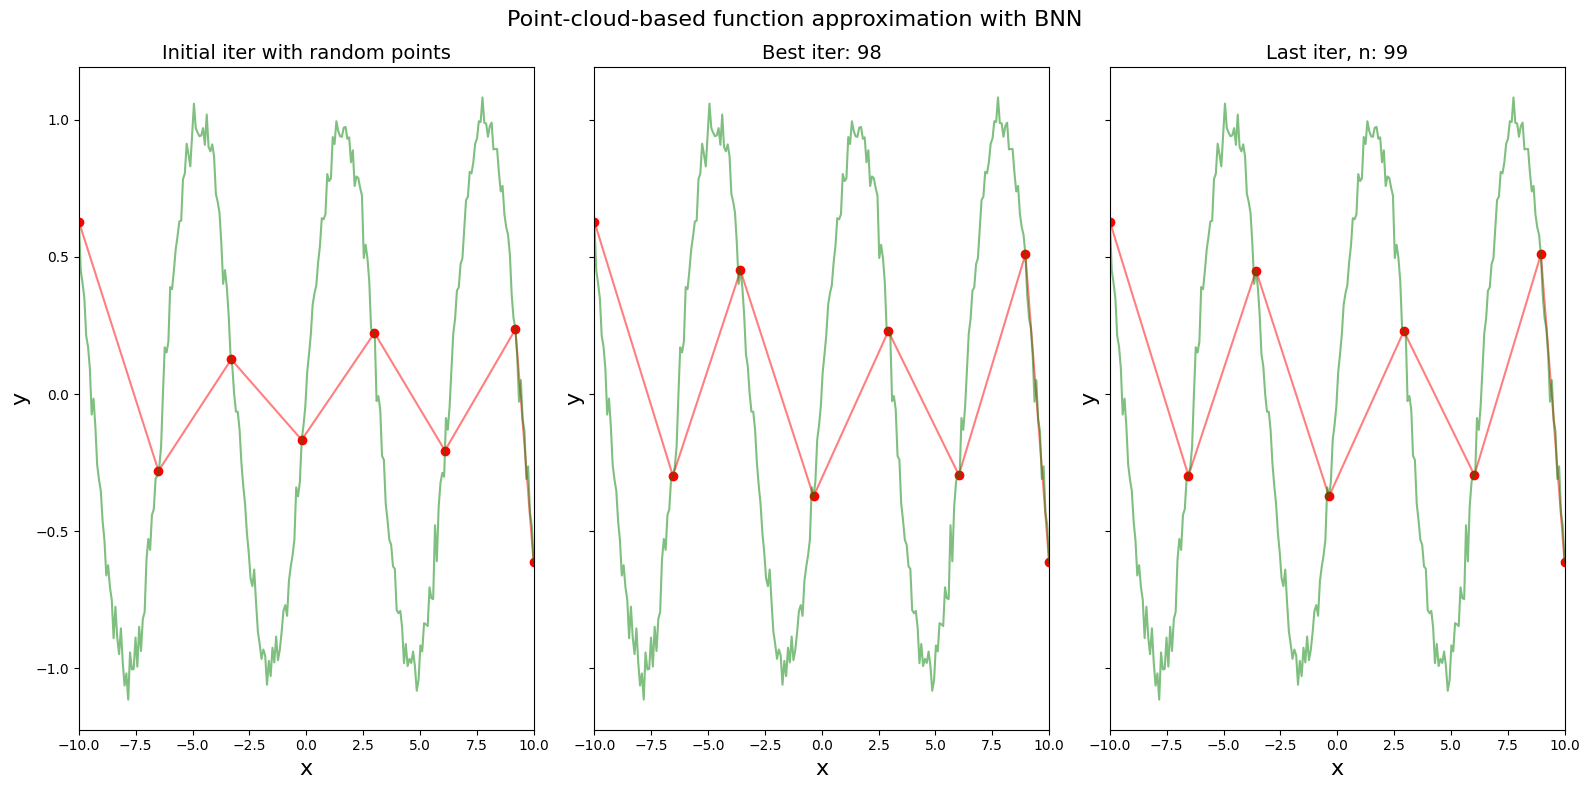

In [4]:
domain =[-10,10]
num_points=250
function=np.sin
x_train, y_train = generate_training_data(function, (domain[0], domain[1]), num_points)
np.random.seed(7)
ruido = np.random.normal(0, 0.05, size=x_train.shape)
y_train = y_train + ruido
x_train = tf.constant(x_train,dtype=tf.float32)
y_train = tf.constant(y_train,dtype=tf.float32)

stbase = gd.SimplexTree()
for i in range(num_points-1):
    stbase.insert([i,i+1], -1e10) # aqui definimos que cada elemento esta conectado com su siguiente, ya que lo que tenemos es una linea, una serie temporal
layer = LowerStarLayer(simplextree=stbase)
dgmsRef = layer.call(tf.Variable(y_train))
dgmRef = dgmsRef[0][0]

PERef=persistent_entropy(dgmRef)
LWPERef=length_weighted_persistent_entropy(dgmRef)

x_points = tf.Variable([-10,-6.5,-3.3,-0.2,3.,6.1,9.2,10], dtype=tf.float32 ,trainable=True)
num_points_aprox = x_points.shape[0]
best_mse = float('inf')  
num_iter = 100  
best_iter = 0

metricas = {
    "$MSE$": [],
    "$PE$": [],
    "$LWPE$": [],
}

optimizer = tf.keras.optimizers.SGD(learning_rate=0.1)

for epoch in tqdm(range(num_iter)):
    with tf.GradientTape() as tape:
        tape.watch(x_points)
        y_points = interpolation_tf(x_train,y_train, x_points)
        points = tf.stack([x_points,y_points],axis=1)
        model = BaricentricNetwork(points)
        y_aprox = model(tf.expand_dims(x_train,axis=1))
        dgmsAprox = layer.call(y_aprox)
        dgmAprox = dgmsAprox[0][0]
        mseActual = mse_fn(y_train,y_aprox)
        PELoss = PersistentEntropyLoss()
        PELossValue = PELoss(dgmRef, dgmAprox)

    
    dgmsAprox = layer.call(y_aprox)
    dgmAprox = dgmsAprox[0][0]
    PEAproxActual=persistent_entropy(dgmAprox)
    LWPEAproxActual=length_weighted_persistent_entropy(dgmAprox)

    lossFunction = PersistentEntropyLoss()
    entropyLoss = lossFunction(dgmRef,dgmAprox)
    metricas["$PE$"].append(PEAproxActual.numpy().item())
    metricas["$LWPE$"].append(LWPEAproxActual.numpy().item())

    gradients = tape.gradient(PELossValue,[x_points])
    gradients[0] = tf.tensor_scatter_nd_update(gradients[0], [[0], [num_points_aprox - 1]], [0.0, 0.0]) # we keep constant the two extrema points
    metricas["$MSE$"].append(mseActual.numpy().item())

    if epoch == 0:
        initial_model = model
        initial_x_points = tf.identity(x_points)
        initial_y_points = tf.identity(y_points)
        initial_PE = PEAproxActual
        initial_LWPE = LWPEAproxActual

    if mseActual < best_mse:
        best_mse = mseActual
        no_improvement_counter = 0
        best_x_points = tf.identity(x_points)
        best_y_points = tf.identity(y_points)
        best_model = model
        best_iter = epoch
        best_PE = PEAproxActual
        best_LWPE = LWPEAproxActual
    

    if epoch < num_iter - 1:
        optimizer.apply_gradients(zip(gradients, [x_points]))
        y_points = tf.math.sin(x_points)
        PEAproxPrevio = PEAproxActual
        msePrevio = mseActual
    else:
        last_model = model
        last_x_points = tf.identity(x_points)
        last_y_points = tf.identity(y_points)
        last_PE = PEAproxActual
        last_LWPE = LWPEAproxActual
        
    
metricasPE_withnoise = metricas.copy()

fig, axs = plt.subplots(1, 3, figsize=(16, 8), sharex=True, sharey=True)
axs[0].plot(x_train, initial_model(tf.expand_dims(x_train,axis=1)), 'r-', label=f'$BNN(x), PE(BNN(x)) = {np.round(initial_PE.numpy().item(),6)}$', alpha=0.5)
axs[0].plot(x_train, y_train, 'g-', label=f'$f(x), PE(f(x)) = {np.round(PERef.numpy().item(),6)}$', alpha=0.5)
axs[0].scatter(initial_x_points, initial_y_points, color="red", label="BNN Points creation")
axs[0].set_xlabel('x', fontsize=fontsize)
axs[0].set_ylabel('y', fontsize=fontsize)
axs[0].set_xlim((domain[0],domain[1]))
axs[0].set_title(f'Initial iter with random points',fontsize=14)
# axs[0].legend(loc="lower left",fontsize=12, framealpha=0.5)
axs[1].plot(x_train, best_model(tf.expand_dims(x_train,axis=1)), 'r-', label=f'$BNN(x), PE(BNN(x)) = {np.round(best_PE.numpy().item(),6)}$', alpha=0.5)
axs[1].plot(x_train, y_train, 'g-', label=f'$f(x), PE(f(x)) = {np.round(PERef.numpy().item(),6)}$', alpha=0.5)
axs[1].scatter(best_x_points, best_y_points, color="red", label="BNN Points creation")
axs[1].set_xlabel('x', fontsize=fontsize)
axs[1].set_ylabel('y', fontsize=fontsize)
axs[1].set_xlim((domain[0],domain[1]))
axs[1].set_title(f'Best iter: {best_iter}',fontsize=14)
# axs[1].legend(loc="lower left",fontsize=12, framealpha=0.5)
axs[2].plot(x_train, last_model(tf.expand_dims(x_train,axis=1)), 'r-', label=f'$BNN(x), PE(BNN(x)) = {np.round(last_PE.numpy().item(),6)}$', alpha=0.5)
axs[2].plot(x_train, y_train, 'g-', label=f'$f(x), PE(f(x)) = {np.round(PERef.numpy().item(),6)}$', alpha=0.5)
axs[2].scatter(last_x_points, last_y_points, color="red", label="BNN Points creation")
axs[2].set_xlabel('x', fontsize=fontsize)
axs[2].set_ylabel('y', fontsize=fontsize)
axs[2].set_xlim((domain[0],domain[1]))
axs[2].set_title(f'Last iter, n: {num_iter-1}',fontsize=14)
# axs[2].legend(loc="lower left",fontsize=12, framealpha=0.5)
plt.suptitle("Point-cloud-based function approximation with BNN",fontsize=16)
plt.savefig('figures/WithNoise_PE.png', dpi=300, bbox_inches='tight')
plt.tight_layout()
plt.show()

# Lenght-Weighted Persistent Entropy

$LWPE = - \sum_{i \in I} l_i \cdot \ln p_i$

where $p_i = \frac{\ell_i}{L}, \ell_i = d_i - b_i, L = \sum_{i \in I} \ell_i$.

\begin{equation}
    L_{LWPE} = |LWPE_{ref} - LWPE_{pred}|
\end{equation}

## Point cloud without noise

100%|██████████| 100/100 [00:30<00:00,  3.26it/s]


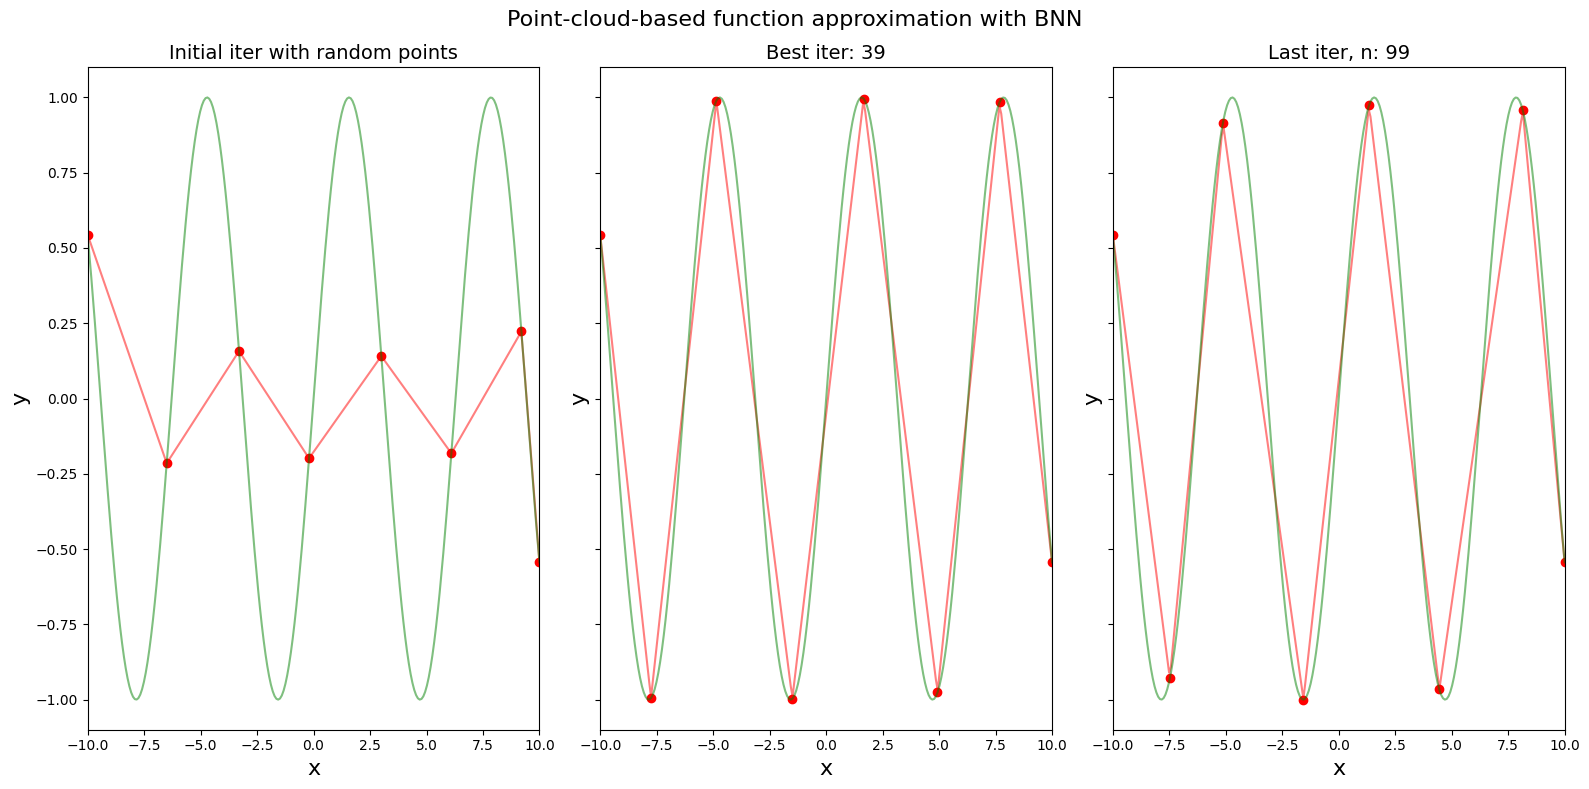

In [13]:
domain =[-10,10]
num_points=250
function=np.sin
x_train, y_train = generate_training_data(function, (domain[0], domain[1]), num_points)
x_train = tf.constant(x_train,dtype=tf.float32)
y_train = tf.constant(y_train,dtype=tf.float32)

stbase = gd.SimplexTree()
for i in range(num_points-1):
    stbase.insert([i,i+1], -1e10) # aqui definimos que cada elemento esta conectado com su siguiente, ya que lo que tenemos es una linea, una serie temporal
layer = LowerStarLayer(simplextree=stbase)
dgmsRef = layer.call(tf.Variable(y_train))
dgmRef = dgmsRef[0][0]

PERef=persistent_entropy(dgmRef)
LWPERef=length_weighted_persistent_entropy(dgmRef)

x_points = tf.Variable([-10,-6.5,-3.3,-0.2,3.,6.1,9.2,10], dtype=tf.float32 ,trainable=True)
num_points_aprox = x_points.shape[0]
best_mse = float('inf')  
num_iter = 100  
best_iter = 0

metricas = {
    "$MSE$": [],
    "$PE$": [],
    "$LWPE$": [],
}

optimizer = tf.keras.optimizers.SGD(learning_rate=0.1)

for epoch in tqdm(range(num_iter)):
    with tf.GradientTape() as tape:
        tape.watch(x_points)
        y_points = interpolation_tf(x_train,y_train, x_points)
        points = tf.stack([x_points,y_points],axis=1)
        model = BaricentricNetwork(points)
        y_aprox = model(tf.expand_dims(x_train,axis=1))
        dgmsAprox = layer.call(y_aprox)
        dgmAprox = dgmsAprox[0][0]
        mseActual = mse_fn(y_train,y_aprox)
        LWPELoss = LengthWeightedPersistentEntropyLoss()
        LWPELossValue = LWPELoss(dgmRef, dgmAprox)
    
    PEAproxActual=persistent_entropy(dgmAprox)
    LWPEAproxActual=length_weighted_persistent_entropy(dgmAprox)

   
    metricas["$PE$"].append(PEAproxActual.numpy().item())
    metricas["$LWPE$"].append(LWPEAproxActual.numpy().item())

    gradients = tape.gradient(LWPELossValue,[x_points])
    gradients[0] = tf.tensor_scatter_nd_update(gradients[0], [[0], [num_points_aprox - 1]], [0.0, 0.0]) # we keep constant the two extrema points
    metricas["$MSE$"].append(mseActual.numpy().item())

    if epoch == 0:
        initial_model = model
        initial_x_points = tf.identity(x_points)
        initial_y_points = tf.identity(y_points)
        initial_PE = PEAproxActual
        initial_LWPE = LWPEAproxActual

    if mseActual < best_mse:
        best_mse = mseActual
        no_improvement_counter = 0
        best_x_points = tf.identity(x_points)
        best_y_points = tf.identity(y_points)
        best_model = model
        best_iter = epoch
        best_PE = PEAproxActual
        best_LWPE = LWPEAproxActual
    

    if epoch < num_iter - 1:
        optimizer.apply_gradients(zip(gradients, [x_points]))
        y_points = tf.math.sin(x_points)
        PEAproxPrevio = PEAproxActual
        msePrevio = mseActual
    else:
        last_model = model
        last_x_points = tf.identity(x_points)
        last_y_points = tf.identity(y_points)
        last_PE = PEAproxActual
        last_LWPE = LWPEAproxActual
        
    
metricasLWPE_withoutnoise = metricas.copy()

fig, axs = plt.subplots(1, 3, figsize=(16, 8), sharex=True, sharey=True)
axs[0].plot(x_train, initial_model(tf.expand_dims(x_train,axis=1)), 'r-', label=f'$BNN(x), PE(BNN(x)) = {np.round(initial_PE.numpy().item(),6)}$', alpha=0.5)
axs[0].plot(x_train, y_train, 'g-', label=f'$f(x), PE(f(x)) = {np.round(PERef.numpy().item(),6)}$', alpha=0.5)
axs[0].scatter(initial_x_points, initial_y_points, color="red", label="BNN Points creation")
axs[0].set_xlabel('x', fontsize=fontsize)
axs[0].set_ylabel('y', fontsize=fontsize)
axs[0].set_xlim((domain[0],domain[1]))
axs[0].set_title(f'Initial iter with random points',fontsize=14)
# axs[0].legend(loc="lower left",fontsize=12, framealpha=0.5)
axs[1].plot(x_train, best_model(tf.expand_dims(x_train,axis=1)), 'r-', label=f'$BNN(x), PE(BNN(x)) = {np.round(best_PE.numpy().item(),6)}$', alpha=0.5)
axs[1].plot(x_train, y_train, 'g-', label=f'$f(x), PE(f(x)) = {np.round(PERef.numpy().item(),6)}$', alpha=0.5)
axs[1].scatter(best_x_points, best_y_points, color="red", label="BNN Points creation")
axs[1].set_xlabel('x', fontsize=fontsize)
axs[1].set_ylabel('y', fontsize=fontsize)
axs[1].set_xlim((domain[0],domain[1]))
axs[1].set_title(f'Best iter: {best_iter}',fontsize=14)
# axs[1].legend(loc="lower left",fontsize=12, framealpha=0.5)
axs[2].plot(x_train, last_model(tf.expand_dims(x_train,axis=1)), 'r-', label=f'$BNN(x), PE(BNN(x)) = {np.round(last_PE.numpy().item(),6)}$', alpha=0.5)
axs[2].plot(x_train, y_train, 'g-', label=f'$f(x), PE(f(x)) = {np.round(PERef.numpy().item(),6)}$', alpha=0.5)
axs[2].scatter(last_x_points, last_y_points, color="red", label="BNN Points creation")
axs[2].set_xlabel('x', fontsize=fontsize)
axs[2].set_ylabel('y', fontsize=fontsize)
axs[2].set_xlim((domain[0],domain[1]))
axs[2].set_title(f'Last iter, n: {num_iter-1}',fontsize=14)
# axs[2].legend(loc="lower left",fontsize=12, framealpha=0.5)
plt.suptitle("Point-cloud-based function approximation with BNN",fontsize=16)
plt.savefig('figures/WithoutNoise_LWPE.png', dpi=300, bbox_inches='tight')
plt.tight_layout()
plt.show()

## Point cloud with noise

100%|██████████| 100/100 [00:29<00:00,  3.39it/s]


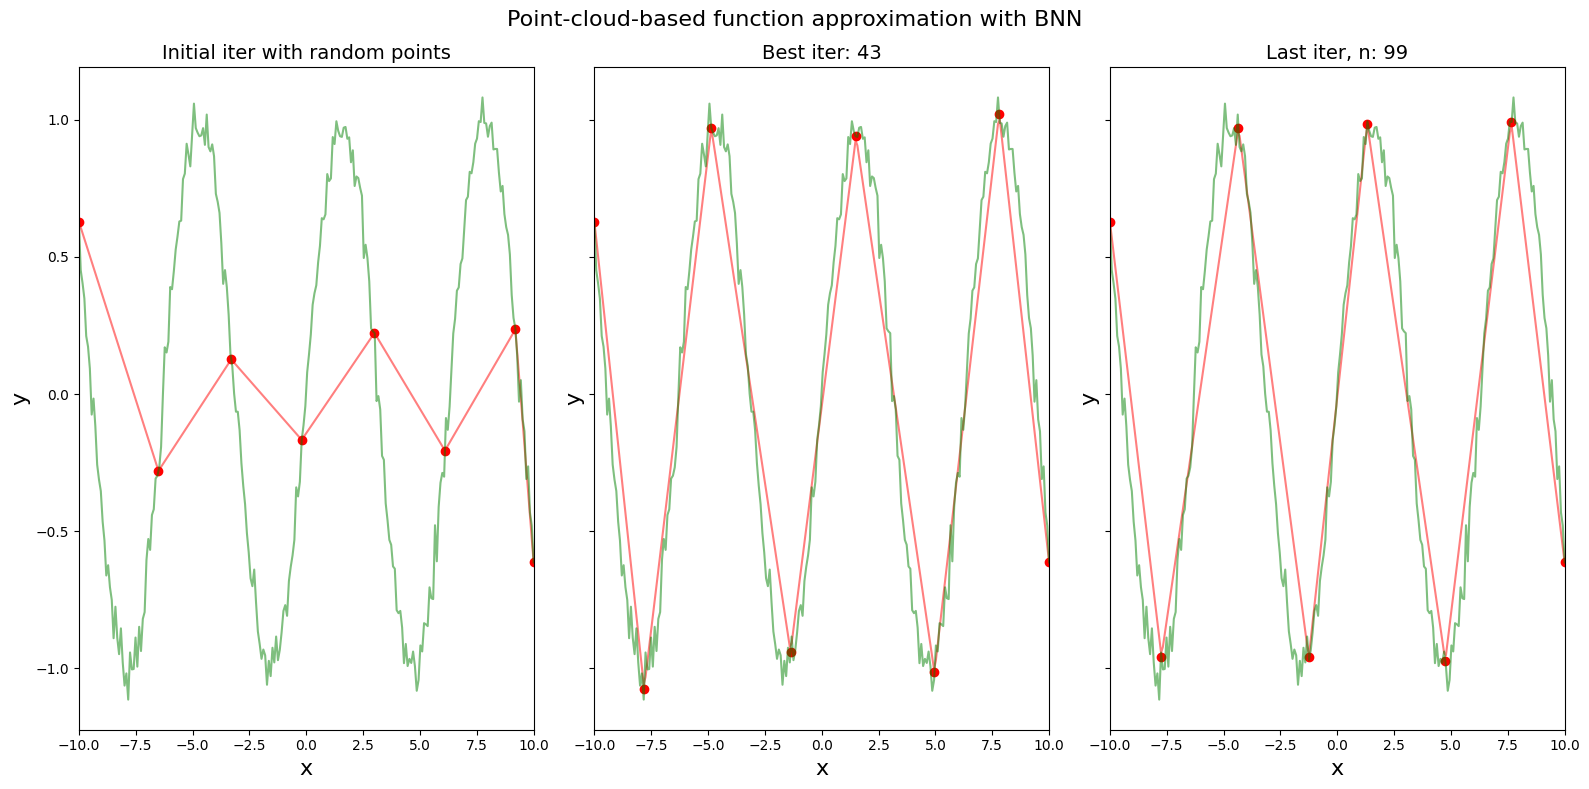

In [6]:
domain =[-10,10]
num_points=250
function=np.sin
x_train, y_train = generate_training_data(function, (domain[0], domain[1]), num_points)
np.random.seed(7)
ruido = np.random.normal(0, 0.05, size=x_train.shape)
y_train = y_train + ruido
x_train = tf.constant(x_train,dtype=tf.float32)
y_train = tf.constant(y_train,dtype=tf.float32)

stbase = gd.SimplexTree()
for i in range(num_points-1):
    stbase.insert([i,i+1], -1e10) # aqui definimos que cada elemento esta conectado com su siguiente, ya que lo que tenemos es una linea, una serie temporal
layer = LowerStarLayer(simplextree=stbase)
dgmsRef = layer.call(tf.Variable(y_train))
dgmRef = dgmsRef[0][0]

PERef=persistent_entropy(dgmRef)
LWPERef=length_weighted_persistent_entropy(dgmRef)

x_points = tf.Variable([-10,-6.5,-3.3,-0.2,3.,6.1,9.2,10], dtype=tf.float32 ,trainable=True)
num_points_aprox = x_points.shape[0]
best_mse = float('inf')  
num_iter = 100  
best_iter = 0

metricas = {
    "$MSE$": [],
    "$PE$": [],
    "$LWPE$": [],
}

optimizer = tf.keras.optimizers.SGD(learning_rate=0.1)

for epoch in tqdm(range(num_iter)):
    with tf.GradientTape() as tape:
        tape.watch(x_points)
        y_points = interpolation_tf(x_train,y_train, x_points)
        points = tf.stack([x_points,y_points],axis=1)
        model = BaricentricNetwork(points)
        y_aprox = model(tf.expand_dims(x_train,axis=1))
        dgmsAprox = layer.call(y_aprox)
        dgmAprox = dgmsAprox[0][0]
        mseActual = mse_fn(y_train,y_aprox)
        LWPELoss = LengthWeightedPersistentEntropyLoss()
        LWPELossValue = LWPELoss(dgmRef, dgmAprox)
    
    PEAproxActual=persistent_entropy(dgmAprox)
    LWPEAproxActual=length_weighted_persistent_entropy(dgmAprox)

   
    metricas["$PE$"].append(PEAproxActual.numpy().item())
    metricas["$LWPE$"].append(LWPEAproxActual.numpy().item())

    gradients = tape.gradient(LWPELossValue,[x_points])
    gradients[0] = tf.tensor_scatter_nd_update(gradients[0], [[0], [num_points_aprox - 1]], [0.0, 0.0]) # we keep constant the two extrema points
    metricas["$MSE$"].append(mseActual.numpy().item())

    if epoch == 0:
        initial_model = model
        initial_x_points = tf.identity(x_points)
        initial_y_points = tf.identity(y_points)
        initial_PE = PEAproxActual
        initial_LWPE = LWPEAproxActual

    if mseActual < best_mse:
        best_mse = mseActual
        no_improvement_counter = 0
        best_x_points = tf.identity(x_points)
        best_y_points = tf.identity(y_points)
        best_model = model
        best_iter = epoch
        best_PE = PEAproxActual
        best_LWPE = LWPEAproxActual
    

    if epoch < num_iter - 1:
        optimizer.apply_gradients(zip(gradients, [x_points]))
        y_points = tf.math.sin(x_points)
        PEAproxPrevio = PEAproxActual
        msePrevio = mseActual
    else:
        last_model = model
        last_x_points = tf.identity(x_points)
        last_y_points = tf.identity(y_points)
        last_PE = PEAproxActual
        last_LWPE = LWPEAproxActual
        
    
metricasLWPE_withnoise = metricas.copy()

fig, axs = plt.subplots(1, 3, figsize=(16, 8), sharex=True, sharey=True)
axs[0].plot(x_train, initial_model(tf.expand_dims(x_train,axis=1)), 'r-', label=f'$BNN(x), PE(BNN(x)) = {np.round(initial_PE.numpy().item(),6)}$', alpha=0.5)
axs[0].plot(x_train, y_train, 'g-', label=f'$f(x), PE(f(x)) = {np.round(PERef.numpy().item(),6)}$', alpha=0.5)
axs[0].scatter(initial_x_points, initial_y_points, color="red", label="BNN Points creation")
axs[0].set_xlabel('x', fontsize=fontsize)
axs[0].set_ylabel('y', fontsize=fontsize)
axs[0].set_xlim((domain[0],domain[1]))
axs[0].set_title(f'Initial iter with random points',fontsize=14)
# axs[0].legend(loc="lower left",fontsize=12, framealpha=0.5)
axs[1].plot(x_train, best_model(tf.expand_dims(x_train,axis=1)), 'r-', label=f'$BNN(x), PE(BNN(x)) = {np.round(best_PE.numpy().item(),6)}$', alpha=0.5)
axs[1].plot(x_train, y_train, 'g-', label=f'$f(x), PE(f(x)) = {np.round(PERef.numpy().item(),6)}$', alpha=0.5)
axs[1].scatter(best_x_points, best_y_points, color="red", label="BNN Points creation")
axs[1].set_xlabel('x', fontsize=fontsize)
axs[1].set_ylabel('y', fontsize=fontsize)
axs[1].set_xlim((domain[0],domain[1]))
axs[1].set_title(f'Best iter: {best_iter}',fontsize=14)
# axs[1].legend(loc="lower left",fontsize=12, framealpha=0.5)
axs[2].plot(x_train, last_model(tf.expand_dims(x_train,axis=1)), 'r-', label=f'$BNN(x), PE(BNN(x)) = {np.round(last_PE.numpy().item(),6)}$', alpha=0.5)
axs[2].plot(x_train, y_train, 'g-', label=f'$f(x), PE(f(x)) = {np.round(PERef.numpy().item(),6)}$', alpha=0.5)
axs[2].scatter(last_x_points, last_y_points, color="red", label="BNN Points creation")
axs[2].set_xlabel('x', fontsize=fontsize)
axs[2].set_ylabel('y', fontsize=fontsize)
axs[2].set_xlim((domain[0],domain[1]))
axs[2].set_title(f'Last iter, n: {num_iter-1}',fontsize=14)
# axs[2].legend(loc="lower left",fontsize=12, framealpha=0.5)
plt.suptitle("Point-cloud-based function approximation with BNN",fontsize=16)
plt.savefig('figures/WithNoise_LWPE.png', dpi=300, bbox_inches='tight')
plt.tight_layout()
plt.show()

# Comparing them

## Without noise

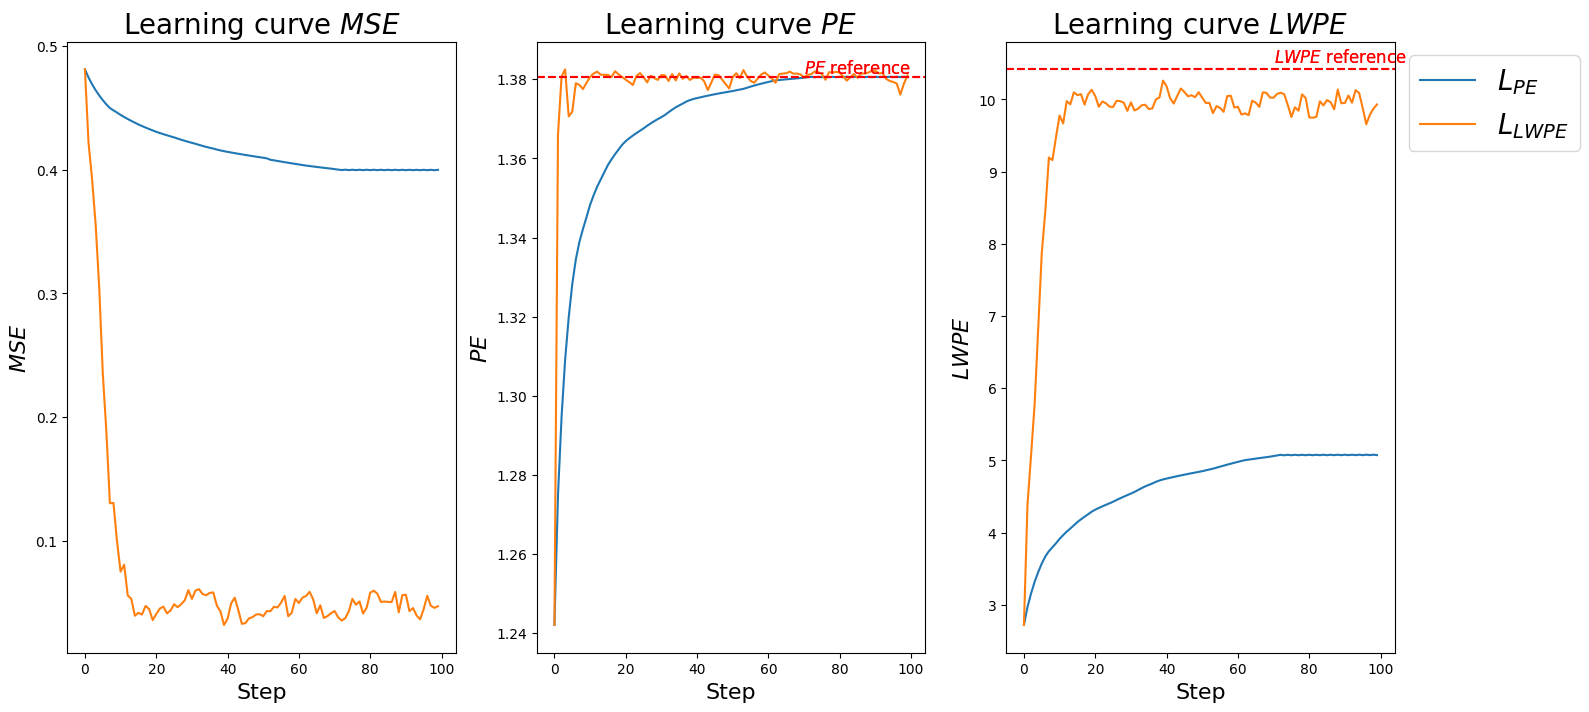

In [14]:
fig, axes = plt.subplots(1, 3, figsize=(16, 8), sharex=True)
axes = axes.flatten()
labels = ["$L_{PE}$", "$L_{LWPE}$"]

for i, metric in enumerate([metricasPE_withoutnoise, metricasLWPE_withoutnoise]):
    for num, (nombre, metrica) in enumerate(metric.items(), start=0):
        plt.sca(axes[num])
        plt.plot(metrica, label=labels[i])  # Solo estos labels irán en la leyenda global
        plt.title(f"Learning curve {nombre}", fontsize=20)
        plt.xlabel("Step")
        plt.ylabel(f"{nombre}")

        # Agregar líneas de referencia solo dentro del subgráfico
        if num == 1:
            axes[num].axhline(y=PERef, color='red', linestyle='--')
            axes[num].text(len(metrica) * 0.7, PERef+0.001, "$PE$ reference", color='red', fontsize=12)

        if num == 2:
            axes[num].axhline(y=LWPERef, color='red', linestyle='--')
            axes[num].text(len(metrica) * 0.7, LWPERef+0.1, "$LWPE$ reference", color='red', fontsize=12)

# Solo mostrar la leyenda de plt.plot()
plt.legend(bbox_to_anchor=(1, 1), fontsize=20)
plt.tight_layout()
plt.savefig('figures/WithoutNoiseComparisonPE.png', dpi=300, bbox_inches='tight')
plt.show()


$L_{LWPE}$ is better

## With noise

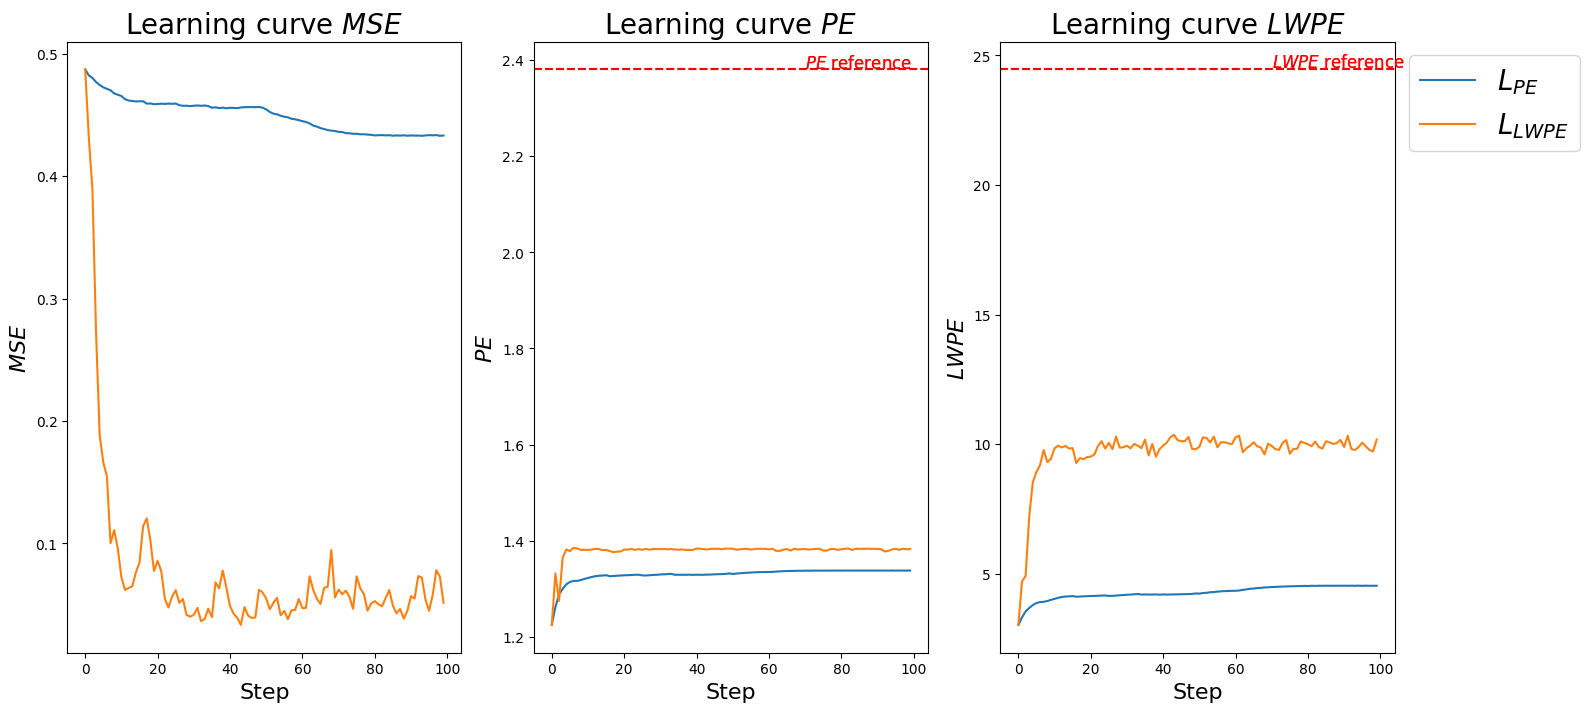

In [11]:
fig, axes = plt.subplots(1, 3, figsize=(16, 8), sharex=True)
axes = axes.flatten()
labels = ["$L_{PE}$", "$L_{LWPE}$"]

for i, metric in enumerate([metricasPE_withnoise, metricasLWPE_withnoise]):
    for num, (nombre, metrica) in enumerate(metric.items(), start=0):
        plt.sca(axes[num])
        plt.plot(metrica, label=labels[i])  # Solo estos labels irán en la leyenda global
        plt.title(f"Learning curve {nombre}", fontsize=20)
        plt.xlabel("Step")
        plt.ylabel(f"{nombre}")

        # Agregar líneas de referencia solo dentro del subgráfico
        if num == 1:
            axes[num].axhline(y=PERef, color='red', linestyle='--')
            axes[num].text(len(metrica) * 0.7, PERef+0.003, "$PE$ reference", color='red', fontsize=12)

        if num == 2:
            axes[num].axhline(y=LWPERef, color='red', linestyle='--')
            axes[num].text(len(metrica) * 0.7, LWPERef+0.1, "$LWPE$ reference", color='red', fontsize=12)

# Solo mostrar la leyenda de plt.plot()
plt.legend(bbox_to_anchor=(1, 1), fontsize=20)
plt.tight_layout()
plt.savefig('figures/WithNoiseComparisonPE.png', dpi=300, bbox_inches='tight')
plt.show()

**Conclusion**: $L_{LWPE}$ is better